# Affine Transform - Generate Neural Network

## Introduction

In this code, we generate a neural network that predicts the transformed (rotated) value of the input point.

We then enforce a constraint on the output set such that we require the transformed (rotated) points to stay within a certain box. These constraints can be defined in the form of $Ax < b$. 

The idea is to repair the layers of the original neural network train in order to ensure the following two cases:

1. If true transformed (rotated) points are following the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points as well as follow the constraint; and

2. If true transformed (rotated) points are violating the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points but also follow the constraint.
-----------------


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow import keras
import numpy as np
from shapely.geometry import Polygon, Point
from affine_utils import gen_rand_points_within_poly, Batch
import pickle
import os
import argparse
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
path = os.path.join(os.getcwd(), "original_net")
if not os.path.exists(path):
    os.makedirs(path)
    print("The new directory is created!")
    

## Data Generation

Start by creating a dataset for the neural network that learns an Affine Transform in a 2d space.

In [3]:
num_pts = 300  # number of samples
train2test_ratio = 0.7
## affine transformation matrices
translate1 = np.array(
    [[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]]
)  # translation matrix 1
translate2 = np.array(
    [[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]]
)  # translation matrix 2
rotate = np.array(
    [
        [np.cos(np.pi / 4), -np.sin(np.pi / 4), 0],
        [np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
        [0, 0, 1],
    ]
)  # rotation matrix
## original, transformed, and constraint Polygons
poly_orig = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly_trans = Polygon(
    [(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)]
)
vert_const_inp = np.array(
    [[1.25, 3.75, 3.75, 1.25], [1.25, 1.25, 3.75, 3.75], [1, 1, 1, 1]]
)  # contraint vertices in input space
vert_const_out = np.matmul(
    np.matmul(np.matmul(translate1, rotate), translate2), vert_const_inp
)  # constraint vertices in output space
poly_const = Polygon(
    [
        (vert_const_out[0, 0], vert_const_out[1, 0]),
        (vert_const_out[0, 1], vert_const_out[1, 1]),
        (vert_const_out[0, 2], vert_const_out[1, 2]),
        (vert_const_out[0, 3], vert_const_out[1, 3]),
    ]
)


In [4]:
x = gen_rand_points_within_poly(poly_orig, num_pts)
y = np.matmul(np.matmul(np.matmul(translate1, rotate), translate2), x.T)
y = y.T
## construct a data batch class
batch_size = int(train2test_ratio * num_pts)
batch = Batch(x, y, batch_size)
x_train, y_train, x_test, y_test = batch.get_batch()
print("Data size: {}".format(num_pts))
print("Train/Test Split: {}".format(train2test_ratio))
print(f"Training Set Size = {x_train.shape}")
print(f"Testing Set Size = {x_test.shape}")


Data size: 300
Train/Test Split: 0.7
Training Set Size = (210, 3)
Testing Set Size = (90, 3)


In [5]:
x_train_tensor = x_train.astype(np.float32)
y_train_tensor = y_train.astype(np.float32)
x_test_tensor = x_test.astype(np.float32)
y_test_tensor = y_test.astype(np.float32)

train_set = []
for i in range(x_train.shape[0]):
    train_set.append([x_train_tensor[i,:], y_train_tensor[i,:]])

test_set = []
for i in range(x_test.shape[0]):
    test_set.append([x_test_tensor[i,:], y_test_tensor[i,:]])


# print(train_set)                                      
trainloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

## Neural Network Specification

Now that we have the dataset ready, let us start by defining the neural network to learn this affine transform.

In [6]:
## Network
input_dim = 3
output_dim = 3
hid_dim_0 = 20
hid_dim_1 = 10
architecture = [input_dim, hid_dim_0, hid_dim_1, output_dim]
regularizer_rate = 0.001
train_epochs = 1000
learning_rate = 0.003

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
       
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(architecture[0], architecture[1])  # 5*5 from image dimension
        self.fc2 = nn.Linear(architecture[1], architecture[2])
        self.fc3 = nn.Linear(architecture[2], architecture[3])

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


Now, we train the neural network

In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

loss_hist = []
for e in range(train_epochs):
    running_loss = 0
    for x,y in trainloader:
        # Flatten MNIST images into a 784 long vector
    
        # Training pass
        optimizer.zero_grad()
        params = list(net.parameters())
        output = net(x)
        regu = [torch.mean(x**2).item() for x in params]

        loss = criterion(output, y) + (0.5 * regularizer_rate * sum(regu))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        loss_hist.append(running_loss/len(trainloader))

Training loss: 3.9163403511047363
Training loss: 2.7320498483521596
Training loss: 1.113456855927195
Training loss: 0.3853473109858377
Training loss: 0.3115827089973858
Training loss: 0.24980112803833826
Training loss: 0.19743682444095612
Training loss: 0.15715575803603446
Training loss: 0.11846031780753817
Training loss: 0.0787021533719131
Training loss: 0.051265153368668895
Training loss: 0.041748479407812865
Training loss: 0.02580394542643002
Training loss: 0.01815594729435231
Training loss: 0.013413061354575413
Training loss: 0.008993252413347363
Training loss: 0.00544192420784384
Training loss: 0.004202295244405312
Training loss: 0.002271078102889338
Training loss: 0.0015217836813202926
Training loss: 0.0012261266778555832
Training loss: 0.000956419381379549
Training loss: 0.0007719395486804258
Training loss: 0.0006768488071559529
Training loss: 0.0006157385796541348
Training loss: 0.0005991483256886048
Training loss: 0.0005582290011391576
Training loss: 0.0005211601216745164
Trai

Training loss: 0.0002582395786053634
Training loss: 0.00025824021888963344
Training loss: 0.000258238277248373
Training loss: 0.0002582383167464286
Training loss: 0.0002582393915093105
Training loss: 0.0002582386805443093
Training loss: 0.0002582375496526116
Training loss: 0.0002582372440623918
Training loss: 0.0002582382626964578
Training loss: 0.0002582385766020577
Training loss: 0.00025823868885968944
Training loss: 0.00025823844563482065
Training loss: 0.00025823793216009757
Training loss: 0.0002582381067830803
Training loss: 0.0002582371837758858
Training loss: 0.00025823829180028824
Training loss: 0.0002582381109407704
Training loss: 0.000258237447789205
Training loss: 0.00025823787603128167
Training loss: 0.0002582376473583281
Training loss: 0.0002582372419835467
Training loss: 0.00025823694262986204
Training loss: 0.00025823721080087125
Training loss: 0.0002582372357470116
Training loss: 0.00025823717130281566
Training loss: 0.00025823725029892685
Training loss: 0.0002582374353

Training loss: 0.0002623757401514532
Training loss: 0.00025867494280516567
Training loss: 0.00025860612056151567
Training loss: 0.00025816152836861353
Training loss: 0.0002586186268932319
Training loss: 0.00025938150481254397
Training loss: 0.0002609989190075014
Training loss: 0.00025996945831658583
Training loss: 0.0002630601915630645
Training loss: 0.00026040760193219673
Training loss: 0.00026588480354153683
Training loss: 0.0002634762058733031
Training loss: 0.00026779519352463206
Training loss: 0.0002806310492035534
Training loss: 0.00027593670113544377
Training loss: 0.0002633615949889645
Training loss: 0.00025938846894340325
Training loss: 0.0002592139249567741
Training loss: 0.0002595737896626815
Training loss: 0.0002622168477890747
Training loss: 0.0002612574587276738
Training loss: 0.0002640816320698442
Training loss: 0.00028072414612064937
Training loss: 0.00027136118816477913
Training loss: 0.00026364105204785507
Training loss: 0.00026090399270677675
Training loss: 0.0002631

Training loss: 0.0002585113688837737
Training loss: 0.00025771544356497804
Training loss: 0.0002575917418913117
Training loss: 0.00025806273541612815
Training loss: 0.0002582641048190583
Training loss: 0.00025861263358300287
Training loss: 0.0002619490218681416
Training loss: 0.0002678507111600733
Training loss: 0.0002613118537867974
Training loss: 0.00026067519710133117
Training loss: 0.00025943558596606763
Training loss: 0.00025918869609345814
Training loss: 0.00025956795434467494
Training loss: 0.00025797625754161606
Training loss: 0.00025811223895289004
Training loss: 0.00025762268549962234
Training loss: 0.00025855307883050827
Training loss: 0.0002576666842547378
Training loss: 0.00025747078637193354
Training loss: 0.0002584568116747375
Training loss: 0.00025912324157876095
Training loss: 0.00025762930038451614
Training loss: 0.0002579866787917646
Training loss: 0.00025823127154061306
Training loss: 0.00026181095745414495
Training loss: 0.00027336573943362704
Training loss: 0.0002

Training loss: 0.0002770874728282381
Training loss: 0.00026424382355928956
Training loss: 0.0002664798978782658
Training loss: 0.00026757848848189624
Training loss: 0.00026734615260336014
Training loss: 0.0003048095552782927
Training loss: 0.00035478005468446227
Training loss: 0.0002723802671036018
Training loss: 0.0002810322226391041
Training loss: 0.00027820663152462136
Training loss: 0.0002651126664464495
Training loss: 0.0002691817644517869
Training loss: 0.0002808052210769217
Training loss: 0.000274157477958527
Training loss: 0.00026886319184476245
Training loss: 0.00026903365090090247
Training loss: 0.00029613564090271084
Training loss: 0.00028930091814670177
Training loss: 0.0002964122187612312
Training loss: 0.00028879060534693835
Training loss: 0.0002822570240823552
Training loss: 0.0002840923490501674
Training loss: 0.00026953196460713765
Training loss: 0.0003042214520974085
Training loss: 0.00026472654592778
Training loss: 0.0002670444893218311
Training loss: 0.0002618777465

Model MSE on Train Data Set = 8.116540772817871e-10
Model MSE on Test Data Set = 2.0833536837017164e-05


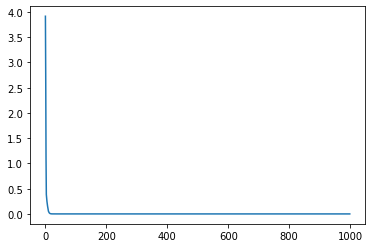

In [9]:
import matplotlib.pyplot as plt

def getMSE(dataloader):
    overall_loss = 0
    for x,y in dataloader: 
        with torch.no_grad():
            out_data = net(x)
            loss = criterion(out_data, y)
            overall_loss += loss

    overall_loss = overall_loss / len(testloader)
    return overall_loss

print(f"Model MSE on Train Data Set = {getMSE(trainloader)}")
print(f"Model MSE on Test Data Set = {getMSE(testloader)}")
plt.plot(loss_hist)

## Input/Output Visualization

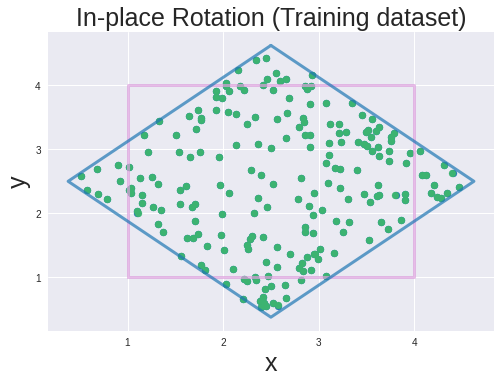

In [10]:
plt.rcParams["text.usetex"] = False
mpl.style.use("seaborn")

x_poly_trans_bound, y_poly_trans_bound = poly_trans.exterior.xy
x_poly_orig_bound, y_poly_orig_bound = poly_orig.exterior.xy

plt.plot(
    x_poly_orig_bound,
    y_poly_orig_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_trans_bound,
    y_poly_trans_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.scatter(
    y_train[:, 0],
    y_train[:, 1],
    color="tab:blue",
    label="Original Target",
)
x_train_tensor = torch.Tensor(x_train)
with torch.no_grad():
    y_predict_tensor = net(x_train_tensor)
y_predict_train = y_predict_tensor.numpy()

plt.scatter(
    y_predict_train[:, 0],
    y_predict_train[:, 1],
    color="mediumseagreen",
    label="Predicted Target",
)
# plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(r"In-place Rotation (Training dataset)", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

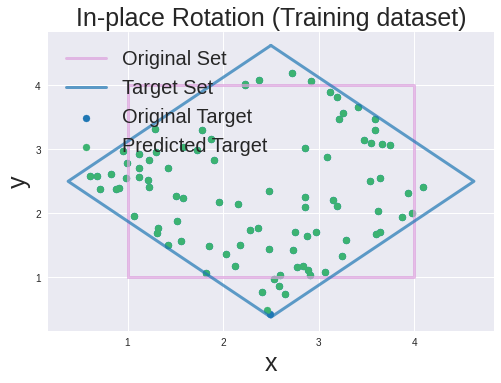

In [11]:
plt.plot(
    x_poly_orig_bound,
    y_poly_orig_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_trans_bound,
    y_poly_trans_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    color="tab:blue",
    label="Original Target",
)
x_test_tensor = torch.Tensor(x_test)
with torch.no_grad():
    y_predict_tensor = net(x_test_tensor)
y_predict_test = y_predict_tensor.numpy()

plt.scatter(
    y_predict_test[:, 0],
    y_predict_test[:, 1],
    color="mediumseagreen",
    label="Predicted Target",
)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(r"In-place Rotation (Training dataset)", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

## Saving Data and Model

In [12]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
fc1.weight 	 torch.Size([20, 3])
fc1.bias 	 torch.Size([20])
fc2.weight 	 torch.Size([10, 20])
fc2.bias 	 torch.Size([10])
fc3.weight 	 torch.Size([3, 10])
fc3.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {0: {'step': 14000, 'exp_avg': tensor([[ 5.0706e-06,  3.7636e-06, -9.9647e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 3.5302e-06,  2.9851e-06, -4.1561e-07],
        [-4.4625e-06, -3.1112e-06, -4.9710e-07],
        [ 6.7782e-07,  5.1186e-07, -7.7024e-07],
        [-2.6023e-06, -1.5564e-06, -3.8251e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.5225e-06, -4.9824e-07, -1.1838e-06],
        [ 1.2336e-06,  8.6650e-07, -7.6732e-07],
        [ 1.1607e-06,  1.4867e-06,  8.8176e-07],
        [ 5.7195e-06,  4.1332e-06, -3.9784e-07],
        [-5.3918e-07,  4.1642e-07,  2.3874e-07],
        [-3.4406e-07, -1.2040e-07, -4.5815e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-4.4310e-06, -2.2977e-06, -4.3376e-07],

In [13]:
if not os.path.exists(path + "/model"):
    os.makedirs(path + "/model")
    
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save(path + "/model/affine_transform_pt_orig_model.pt")


if not os.path.exists(path + "/data"):
    os.makedirs(path + "/data")
with open(path + "/data/input_output_data_tc1.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

In [14]:
with open(path + "/data/input_output_data_tc1.pickle", "rb") as data:
    dataset = pickle.load(data)
## affine transformation matrices
translate1 = np.array(
    [[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]]
)  # translation matrix 1
translate2 = np.array(
    [[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]]
)  # translation matrix 2
rotate = np.array(
    [
        [np.cos(np.pi / 4), -np.sin(np.pi / 4), 0],
        [np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
        [0, 0, 1],
    ]
)  # rotation matrix

## original, transformed, and constraint Polygons
poly_orig = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly_trans = Polygon(
    [(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)]
)
inp_const_vertices = np.array(
    [[1.25, 3.75, 3.75, 1.25], [1.25, 1.25, 3.75, 3.75], [1, 1, 1, 1]]
)  # contraint vertices in input space
out_const_vertices = np.matmul(
    np.matmul(np.matmul(translate1, rotate), translate2), inp_const_vertices
)  # constraint vertices in output space
poly_const = Polygon(
    [
        (out_const_vertices[0, 0], out_const_vertices[1, 0]),
        (out_const_vertices[0, 1], out_const_vertices[1, 1]),
        (out_const_vertices[0, 2], out_const_vertices[1, 2]),
        (out_const_vertices[0, 3], out_const_vertices[1, 3]),
    ]
)

# divide training dataset
x_inside = []
x_outside = []
y_inside = []
y_outside = []

for i in range(dataset[0].shape[0]):
    if Point([dataset[1][i][0], dataset[1][i][1]]).within(poly_const):
        x_inside.append(dataset[0][i])
        y_inside.append(dataset[1][i])
    else:
        x_outside.append(dataset[0][i])
        y_outside.append(dataset[1][i])

if not os.path.exists(path + "/data"):
    os.makedirs(path + "/data")
with open(
    path + "/data/input_output_data_inside_train_tc1.pickle", "wb"
) as data:
    print(f"number of training points inside: {len(y_inside)}")
    pickle.dump([np.array(x_inside), np.array(y_inside)], data)
with open(
    path + "/data/input_output_data_outside_train_tc1.pickle", "wb"
) as data:
    print(f"number of training points outside: {len(y_outside)}")
    pickle.dump([np.array(x_outside), np.array(y_outside)], data)

# divide testing dataset
x_inside = []
x_outside = []
y_inside = []
y_outside = []

for i in range(dataset[2].shape[0]):
    if Point([dataset[3][i][0], dataset[3][i][1]]).within(poly_const):
        x_inside.append(dataset[2][i])
        y_inside.append(dataset[3][i])
    else:
        x_outside.append(dataset[2][i])
        y_outside.append(dataset[3][i])
if not os.path.exists(path + "/data"):
    os.makedirs(path + "/data")
with open(
    path + "/data/input_output_data_inside_test_tc1.pickle", "wb"
) as data:
    print(f"number of testing points inside: {len(y_inside)}")
    pickle.dump([np.array(x_inside), np.array(y_inside)], data)
with open(
    path + "/data/input_output_data_outside_test_tc1.pickle", "wb"
) as data:
    print(f"number of testing points outside: {len(y_outside)}")
    pickle.dump([np.array(x_outside), np.array(y_outside)], data)


number of training points inside: 137
number of training points outside: 73
number of testing points inside: 55
number of testing points outside: 35
